In [7]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import joblib
import pandas as pd

In [33]:
ds = xr.open_dataset("../data/Paper_ds/post_CWU_GAT_2023.nc")[['detrend_input_n', 'detrend_input_e','detrend_input_z', 'final_input_n', 'final_input_e','final_input_z']]
ds

<xarray.Dataset>
Dimensions:          (station: 518, time: 5113)
Coordinates:
  * station          (station) object 'AGNS' 'ALBH' 'ANAT' ... 'YONC' 'ZSE1'
  * time             (time) datetime64[ns] 2010-01-01 2010-01-02 ... 2023-12-31
    longitude        (station) float64 ...
    latitude         (station) float64 ...
    height           (station) float64 ...
Data variables:
    detrend_input_n  (station, time) float32 ...
    detrend_input_e  (station, time) float32 ...
    detrend_input_z  (station, time) float32 ...
    final_input_n    (station, time) float32 ...
    final_input_e    (station, time) float32 ...
    final_input_z    (station, time) float32 ...
Attributes:
    dataset source:   CWU daily solution from earthscope
    data processing:  raw data are detrended for each channel (detrend_input*...

In [34]:
ds_fit = xr.open_dataset("../fit_daily_CWU.nc").sel(time=slice(ds.time.data[0], ds.time.data[-1]))
ds_fit

<xarray.Dataset>
Dimensions:  (station: 518, time: 5113)
Coordinates:
  * station  (station) object 'AGNS' 'ALBH' 'ANAT' ... 'YOCR' 'YONC' 'ZSE1'
  * time     (time) datetime64[ns] 2010-01-01 2010-01-02 ... 2023-12-31
Data variables:
    n        (station, time) float64 ...
    e        (station, time) float64 ...
    z        (station, time) float64 ...

# read tremor dataset

In [35]:
df = pd.read_csv("../tremor_events-2010-01-01T00_00_00-2024-01-01T23_59_59.csv", parse_dates=['starttime'])
df = df.drop(df.columns[[4, 5]],  axis=1)
df['lat'] = df['lat'].round(1)
df['lon'] = df['lon'].round(1)
df = df.set_index('starttime')
df = df.groupby([df.index.date, df.lat, df.lon]).count().reset_index()
df = df.rename(columns={'level_0': 'time', 'depth': 'count'})
tremor = df.set_index(['time', 'lon', 'lat']).to_xarray()
time = pd.date_range(start=ds.time[0].item(), end=ds.time[-1].item(), freq='1D')
tremor = tremor.reindex(time=time)
tremor

/tmp/ipykernel_995698/4022982290.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../tremor_events-2010-01-01T00_00_00-2024-01-01T23_59_59.csv", parse_dates=['starttime'])


<xarray.Dataset>
Dimensions:  (time: 5113, lon: 71, lat: 119)
Coordinates:
  * time     (time) datetime64[ns] 2010-01-01 2010-01-02 ... 2023-12-31
  * lon      (lon) float64 -128.0 -127.9 -127.8 -127.7 ... -121.2 -121.1 -121.0
  * lat      (lat) float64 39.1 39.2 39.3 39.4 39.5 ... 50.5 50.6 50.7 50.8 50.9
Data variables:
    count    (time, lon, lat) float64 nan nan nan nan nan ... nan nan nan nan

In [36]:
def get_tremor_count(longitude, latitude):
    delta_dist = 0.5
    tremor_sel = tremor.sel(
                lon=slice(longitude - delta_dist, longitude + delta_dist),
                lat=slice(latitude - delta_dist, latitude + delta_dist)).sum(dim=['lon', 'lat'])[
                'count']
    return tremor_sel

In [37]:
tremor_dataarray = xr.apply_ufunc(get_tremor_count, ds.longitude, ds.latitude, dask="parallelized", input_core_dims=[[], []], output_core_dims=[['time']], output_dtypes=['float64'], vectorize=True)
tremor_dataarray.compute()
tremor_dataarray

<xarray.DataArray (station: 518, time: 5113)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * station    (station) object 'AGNS' 'ALBH' 'ANAT' ... 'YOCR' 'YONC' 'ZSE1'
    longitude  (station) float64 -124.1 -123.5 -117.1 ... -121.7 -123.3 -122.2
    latitude   (station) float64 42.55 48.39 46.13 48.17 ... 45.38 43.63 47.29
    height     (station) float64 51.37 31.77 1.087e+03 ... 1.884e+03 86.49 82.06
Dimensions without coordinates: time

In [38]:
ds['tremor_count'] = tremor_dataarray
ds

<xarray.Dataset>
Dimensions:          (station: 518, time: 5113)
Coordinates:
  * station          (station) object 'AGNS' 'ALBH' 'ANAT' ... 'YONC' 'ZSE1'
  * time             (time) datetime64[ns] 2010-01-01 2010-01-02 ... 2023-12-31
    longitude        (station) float64 ...
    latitude         (station) float64 ...
    height           (station) float64 ...
Data variables:
    detrend_input_n  (station, time) float32 ...
    detrend_input_e  (station, time) float32 ...
    detrend_input_z  (station, time) float32 ...
    final_input_n    (station, time) float32 ...
    final_input_e    (station, time) float32 ...
    final_input_z    (station, time) float32 ...
    tremor_count     (station, time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    dataset source:   CWU daily solution from earthscope
    data processing:  raw data are detrended for each channel (detrend_input*...

In [39]:
def remove_mean_pos(data_detrend, tre_count):
    tmp_mean_calc = data_detrend.where(tre_count < 2)
    mean_pos = (tmp_mean_calc - tmp_mean_calc.mean(dim="time")).mean(dim="station")
    return data_detrend - mean_pos, mean_pos

In [40]:
for c in ['e', 'n', 'z']:
    tmp_fit = ds_fit[f'{c}'].where(~np.isnan(ds[f'detrend_input_{c}']))
    ds[f'detrend_denoised_{c}'], pred = remove_mean_pos(ds[f'detrend_input_{c}'], ds['tremor_count'])
    ds[f'detrend_pred_{c}'] = pred.expand_dims({'station': ds.station})
    ds[f'final_denoised_{c}'] = ds[f'detrend_denoised_{c}'] + tmp_fit
    ds[f'final_pred_{c}'] = ds[f'detrend_pred_{c}'] + tmp_fit
ds

<xarray.Dataset>
Dimensions:             (station: 518, time: 5113)
Coordinates:
  * station             (station) object 'AGNS' 'ALBH' 'ANAT' ... 'YONC' 'ZSE1'
  * time                (time) datetime64[ns] 2010-01-01 ... 2023-12-31
    longitude           (station) float64 ...
    latitude            (station) float64 ...
    height              (station) float64 ...
Data variables: (12/19)
    detrend_input_n     (station, time) float32 nan nan nan ... 0.0001705 nan
    detrend_input_e     (station, time) float32 nan nan nan ... -0.0009479 nan
    detrend_input_z     (station, time) float32 nan nan nan ... 0.002998 nan
    final_input_n       (station, time) float32 ...
    final_input_e       (station, time) float32 ...
    final_input_z       (station, time) float32 ...
    ...                  ...
    final_denoised_n    (station, time) float64 nan nan nan ... -0.1112 nan
    final_pred_n        (station, time) float64 nan nan nan ... -0.1113 nan
    detrend_denoised_z  (station, time) float32 nan nan nan ... 0.003811 nan
    detrend_pred_z      (station, time) float32 -0.004269 -0.003245 ... nan
    final_denoised_z    (station, time) float64 nan nan nan ... -0.01358 nan
    final_pred_z        (station, time) float64 nan nan nan ... -0.0182 nan
Attributes:
    dataset source:   CWU daily solution from earthscope
    data processing:  raw data are detrended for each channel (detrend_input*...

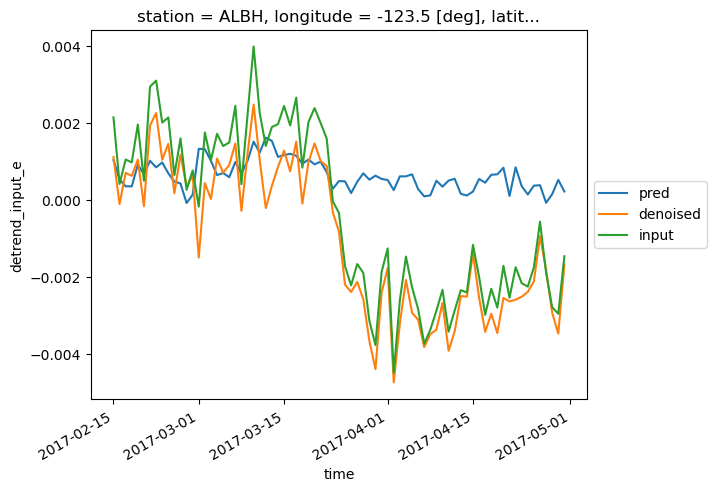

In [41]:
ds.detrend_pred_e.sel(station='ALBH').sel(time=slice('2017-02-15', '2017-04-30')).plot(label="pred")
ds.detrend_denoised_e.sel(station='ALBH').sel(time=slice('2017-02-15', '2017-04-30')).plot(label="denoised")
ds.detrend_input_e.sel(station='ALBH').sel(time=slice('2017-02-15', '2017-04-30')).plot(label="input")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

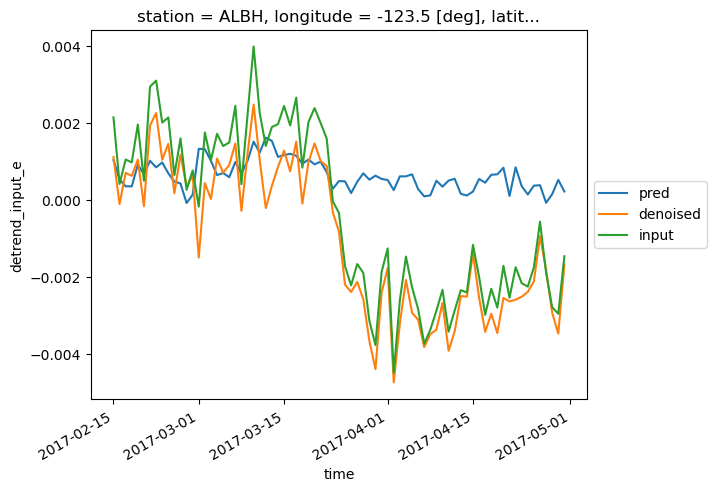

In [42]:
ds.detrend_pred_e.sel(station='ALBH').sel(time=slice('2017-02-15', '2017-04-30')).plot(label="pred")
ds.detrend_denoised_e.sel(station='ALBH').sel(time=slice('2017-02-15', '2017-04-30')).plot(label="denoised")
ds.detrend_input_e.sel(station='ALBH').sel(time=slice('2017-02-15', '2017-04-30')).plot(label="input")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

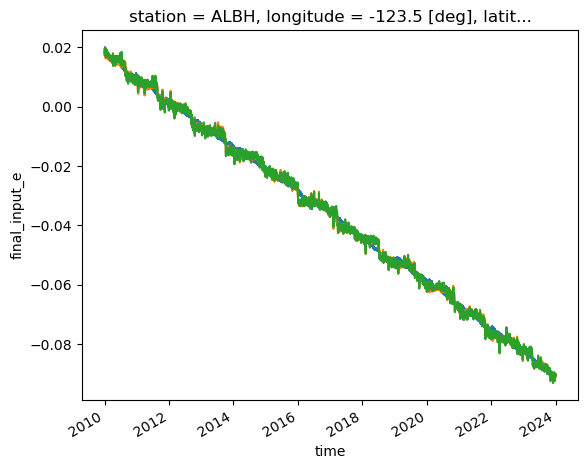

In [43]:
ds.final_pred_e.sel(station='ALBH').plot()
ds.final_denoised_e.sel(station='ALBH').plot()
ds.final_input_e.sel(station='ALBH').plot()

In [44]:
ds

<xarray.Dataset>
Dimensions:             (station: 518, time: 5113)
Coordinates:
  * station             (station) object 'AGNS' 'ALBH' 'ANAT' ... 'YONC' 'ZSE1'
  * time                (time) datetime64[ns] 2010-01-01 ... 2023-12-31
    longitude           (station) float64 ...
    latitude            (station) float64 ...
    height              (station) float64 ...
Data variables: (12/19)
    detrend_input_n     (station, time) float32 nan nan nan ... 0.0001705 nan
    detrend_input_e     (station, time) float32 nan nan nan ... -0.0009479 nan
    detrend_input_z     (station, time) float32 nan nan nan ... 0.002998 nan
    final_input_n       (station, time) float32 ...
    final_input_e       (station, time) float32 ...
    final_input_z       (station, time) float32 ...
    ...                  ...
    final_denoised_n    (station, time) float64 nan nan nan ... -0.1112 nan
    final_pred_n        (station, time) float64 nan nan nan ... -0.1113 nan
    detrend_denoised_z  (station, time) float32 nan nan nan ... 0.003811 nan
    detrend_pred_z      (station, time) float32 -0.004269 -0.003245 ... nan
    final_denoised_z    (station, time) float64 nan nan nan ... -0.01358 nan
    final_pred_z        (station, time) float64 nan nan nan ... -0.0182 nan
Attributes:
    dataset source:   CWU daily solution from earthscope
    data processing:  raw data are detrended for each channel (detrend_input*...

In [45]:
ds.to_netcdf("../data/Paper_ds/avg_position_denoising_daily_no_tremor_CWU.nc")